<a href="https://colab.research.google.com/github/hardikvaniya/Classroom-management-system/blob/master/Financial_distress_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Distress Prediction

Source: https://www.kaggle.com/competitions/GiveMeSomeCredit/

In [1]:
!pip install -q scikit-optimize
!pip install -q shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.2 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn import metrics
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
import shap

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Openning Files

In [4]:
# Getting current working directory
current_dir = os.getcwd()

In [5]:
# Downloading file
!wget -q https://github.com/rdemarqui/financial_distress_prediction/raw/main/datasets/GiveMeSomeCredit.zip

In [6]:
# Opening datasets
zf = zipfile.ZipFile(os.path.join(current_dir, 'GiveMeSomeCredit.zip'))
df_train = pd.read_csv(zf.open('cs-training.csv'), index_col=0, low_memory=False)
df_test = pd.read_csv(zf.open('cs-test.csv'), index_col=0, low_memory=False)

## Exploratory Data Analysis (EDA)

In [7]:
# Checking null values and data types
df_train.shape

(150000, 11)

In [8]:
df_train.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   
3                                2                        1   
4                                5                        0   
5                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                             6                                     0   
2                             0                                     0   
3                             0                                     0   
4                             0                                     0   
5                             1                                     0   

   NumberOfDependents  
1                 2.0  
2                 1.0  
3                 0.0  
4                 0.0  
5                 0.0

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

In [10]:
df_train.describe().T

count         mean           std  \
SeriousDlqin2yrs                      150000.0     0.066840      0.249746   
RevolvingUtilizationOfUnsecuredLines  150000.0     6.048438    249.755371   
age                                   150000.0    52.295207     14.771866   
NumberOfTime30-59DaysPastDueNotWorse  150000.0     0.421033      4.192781   
DebtRatio                             150000.0   353.005076   2037.818523   
MonthlyIncome                         120269.0  6670.221237  14384.674215   
NumberOfOpenCreditLinesAndLoans       150000.0     8.452760      5.145951   
NumberOfTimes90DaysLate               150000.0     0.265973      4.169304   
NumberRealEstateLoansOrLines          150000.0     1.018240      1.129771   
NumberOfTime60-89DaysPastDueNotWorse  150000.0     0.240387      4.155179   
NumberOfDependents                    146076.0     0.757222      1.115086   

                                      min          25%          50%  \
SeriousDlqin2yrs                      0.0     0.000000     0.000000   
RevolvingUtilizationOfUnsecuredLines  0.0     0.029867     0.154181   
age                                   0.0    41.000000    52.000000   
NumberOfTime30-59DaysPastDueNotWorse  0.0     0.000000     0.000000   
DebtRatio                             0.0     0.175074     0.366508   
MonthlyIncome                         0.0  3400.000000  5400.000000   
NumberOfOpenCreditLinesAndLoans       0.0     5.000000     8.000000   
NumberOfTimes90DaysLate               0.0     0.000000     0.000000   
NumberRealEstateLoansOrLines          0.0     0.000000     1.000000   
NumberOfTime60-89DaysPastDueNotWorse  0.0     0.000000     0.000000   
NumberOfDependents                    0.0     0.000000     0.000000   

                                              75%        max  
SeriousDlqin2yrs                         0.000000        1.0  
RevolvingUtilizationOfUnsecuredLines     0.559046    50708.0  
age                                     63.000000      109.0  
NumberOfTime30-59DaysPastDueNotWorse     0.000000       98.0  
DebtRatio                                0.868254   329664.0  
MonthlyIncome                         8249.000000  3008750.0  
NumberOfOpenCreditLinesAndLoans         11.000000       58.0  
NumberOfTimes90DaysLate                  0.000000       98.0  
NumberRealEstateLoansOrLines             2.000000       54.0  
NumberOfTime60-89DaysPastDueNotWorse     0.000000       98.0  
NumberOfDependents                       1.000000       20.0

* Dataset has only numeric features.
* Null values on *MonthlyIncome* and *NumberOfDependents*
* *Age* has some values filled with 0.

Unfortunately few estimators can natively handle missing data. Due to this, we'll fill null values with median, since some features have outliers.

**Correlation Analysis**

At the end of this study we will check which features were most important for the algorithm. Therefore, we need to check whether there is a high correlation between the those features, since collinearity / multicollinearity impacts the study of feature contribution.

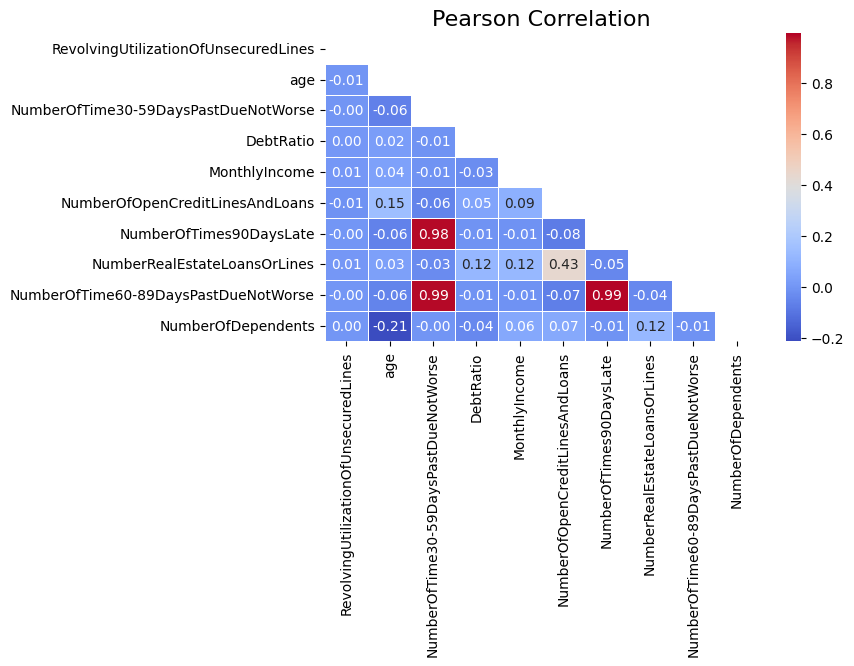

In [11]:
correlation_matrix = df_train.iloc[:, 1:].corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Pearson Correlation', fontsize=16)
plt.show()

As we can see above, we have a high correlation between `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse` and `NumberOfTimes90DaysLate`. In this case, we could maintain only `NumberOfTime30-59DaysPastDueNotWorse`, whereas borrowers who had been late for longer periods were late first in this shorter interval, but in previous tests we've seen that it costs some accuracy points. As accuracy is a sensitive theme in this type of case, we decided to maintain all features.

In [ ]:
#df_train_final = df_train.drop(columns=['NumberOfTime60-89DaysPastDueNotWorse',
#                                        'NumberOfTimes90DaysLate']).copy()

**Filling missing data**

In [12]:
df_train_final = df_train.copy()

fill_MonthlyIncome = df_train_final['MonthlyIncome'].median()
fill_NumberOfDependents = df_train_final['NumberOfDependents'].median()

df_train_final['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
df_train_final['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

<ipython-input-12-8d20c177bd6f>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_final['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
<ipython-input-12-8d20c177bd6f>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [13]:
# Checking y proportion
df_train_final['SeriousDlqin2yrs'].value_counts()/df_train.shape[0]

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: count, dtype: float64

Dataset have inbalance label. We'll tackle this problem applying oversampling in the training step.

In [14]:
# Splitting data
X_train = df_train_final.drop(columns=['SeriousDlqin2yrs'])
y_train = df_train_final['SeriousDlqin2yrs']

##Training

We're going to use cross validation to train all models. In this case we will split in 1/5, where 80% for training and 20% for validation.

In [17]:
def cross_validation(model=None, X=None, y=None, n_splits=5, shuffle=True, oversampling=False, random_state=42):
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
  scores = []

  for idx, (idx_train, idx_validation) in enumerate(kfold.split(X, y)):
    X_train_split = X.iloc[idx_train, :]
    y_train_split = y.iloc[idx_train]

    if oversampling:
      sm = SMOTE(random_state=random_state)
      X_train_split, y_train_split = sm.fit_resample(X_train_split, y_train_split)

    model.fit(X_train_split, y_train_split)

    X_val_split = X.iloc[idx_validation, :]
    y_val_split = y.iloc[idx_validation]

    val_predict = model.predict_proba(X_val_split)[:, 1]

    split_score = round(metrics.roc_auc_score(y_val_split, val_predict), 6)
    scores.append(split_score)

  return scores

In [18]:
def train_models(all_models, oversampling=None):
  all_results = {}
  for model in all_models:
    model_name = str(model).split('(')[0]
    print(f'Training: {model_name}')
    result = cross_validation(model, X_train, y_train, oversampling=oversampling)
    all_results[model_name] = result

  df_results = (pd.DataFrame.from_dict(all_results).T)
  df_results['mean'] = df_results.mean(axis=1)
  df_results = df_results.sort_values(by=['mean'], ascending=False)
  return df_results

### Choosing Best Model

First, we'll try many algorithms to see which one does better.

In [25]:
# Listing all models
mRandState = {'random_state':42}
all_models = [
    AdaBoostClassifier(**mRandState), HistGradientBoostingClassifier(**mRandState),
    ExtraTreesClassifier(**mRandState), RandomForestClassifier(**mRandState),
    LogisticRegression(max_iter=3000, **mRandState), GaussianNB(),
    BernoulliNB(), MultinomialNB(), DecisionTreeClassifier(**mRandState),
    XGBClassifier(**mRandState), LGBMClassifier(verbose=-1, **mRandState)
    ]

#### Oversampling

As seen before, this dataset have inbalance label (93% and 7%). Let's first apply oversampling.

In [ ]:
results_oversampling = train_models(all_models, oversampling=True)

Training: AdaBoostClassifier
Training: HistGradientBoostingClassifier
Training: ExtraTreesClassifier
Training: RandomForestClassifier
Training: LogisticRegression
Training: GaussianNB
Training: BernoulliNB
Training: MultinomialNB
Training: DecisionTreeClassifier
Training: XGBClassifier
Training: LGBMClassifier


In [ ]:
# Checking all results using oversampling
results_oversampling

0         1         2         3  \
HistGradientBoostingClassifier  0.828963  0.835007  0.839808  0.830350   
LGBMClassifier                  0.828483  0.831316  0.837434  0.829035   
ExtraTreesClassifier            0.819238  0.826719  0.831449  0.819978   
RandomForestClassifier          0.814953  0.824280  0.828224  0.819164   
AdaBoostClassifier              0.816548  0.817743  0.829322  0.816280   
XGBClassifier                   0.815077  0.817124  0.821349  0.814809   
BernoulliNB                     0.784014  0.789299  0.796908  0.779174   
LogisticRegression              0.693786  0.813415  0.729233  0.795217   
GaussianNB                      0.685544  0.696976  0.682401  0.667848   
DecisionTreeClassifier          0.626428  0.635741  0.630230  0.638566   
MultinomialNB                   0.755333  0.551972  0.563029  0.548038   

                                       4      mean  
HistGradientBoostingClassifier  0.832577  0.833341  
LGBMClassifier                  0.830404  0.831334  
ExtraTreesClassifier            0.824305  0.824338  
RandomForestClassifier          0.820845  0.821493  
AdaBoostClassifier              0.826966  0.821372  
XGBClassifier                   0.814398  0.816551  
BernoulliNB                     0.794267  0.788732  
LogisticRegression              0.713678  0.749066  
GaussianNB                      0.689921  0.684538  
DecisionTreeClassifier          0.634739  0.633141  
MultinomialNB                   0.682871  0.620249

#### Unbalanced

In [18]:
results_unbalanced = train_models(all_models, oversampling=False)

Training: AdaBoostClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Training: HistGradientBoostingClassifier
Training: ExtraTreesClassifier
Training: RandomForestClassifier
Training: LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training: GaussianNB
Training: BernoulliNB
Training: MultinomialNB
Training: DecisionTreeClassifier
Training: XGBClassifier
Training: LGBMClassifier


In [19]:
# Checking all results using oversampling
results_unbalanced

0         1         2         3  \
LGBMClassifier                  0.862495  0.864936  0.869228  0.859360   
HistGradientBoostingClassifier  0.864703  0.863581  0.869639  0.859239   
AdaBoostClassifier              0.858279  0.860829  0.864372  0.853150   
XGBClassifier                   0.854276  0.856128  0.862880  0.851565   
RandomForestClassifier          0.835511  0.839263  0.843631  0.836495   
ExtraTreesClassifier            0.821132  0.821706  0.825852  0.819680   
BernoulliNB                     0.793406  0.796862  0.800310  0.782885   
GaussianNB                      0.707258  0.711964  0.709642  0.690416   
LogisticRegression              0.691434  0.702972  0.696996  0.696430   
MultinomialNB                   0.730615  0.567083  0.597694  0.557186   
DecisionTreeClassifier          0.612381  0.608981  0.615917  0.615825   

                                       4      mean  
LGBMClassifier                  0.868900  0.864984  
HistGradientBoostingClassifier  0.867612  0.864955  
AdaBoostClassifier              0.860769  0.859480  
XGBClassifier                   0.860235  0.857017  
RandomForestClassifier          0.846033  0.840187  
ExtraTreesClassifier            0.828793  0.823433  
BernoulliNB                     0.805937  0.795880  
GaussianNB                      0.707686  0.705393  
LogisticRegression              0.705000  0.698566  
MultinomialNB                   0.714243  0.633364  
DecisionTreeClassifier          0.614898  0.613600

from matplotlib import pyplot as plt
results_unbalanced[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced[1].plot(kind='hist', bins=20, title=1)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced[2].plot(kind='hist', bins=20, title=2)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced[3].plot(kind='hist', bins=20, title=3)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced.plot(kind='scatter', x=0, y=1, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced.plot(kind='scatter', x=1, y=2, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced.plot(kind='scatter', x=2, y=3, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced.plot(kind='scatter', x=3, y=4, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced[1].plot(kind='line', figsize=(8, 4), title=1)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced[2].plot(kind='line', figsize=(8, 4), title=2)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_unbalanced[3].plot(kind='line', figsize=(8, 4), title=3)
plt.gca().spines[['top', 'right']].set_visible(False)

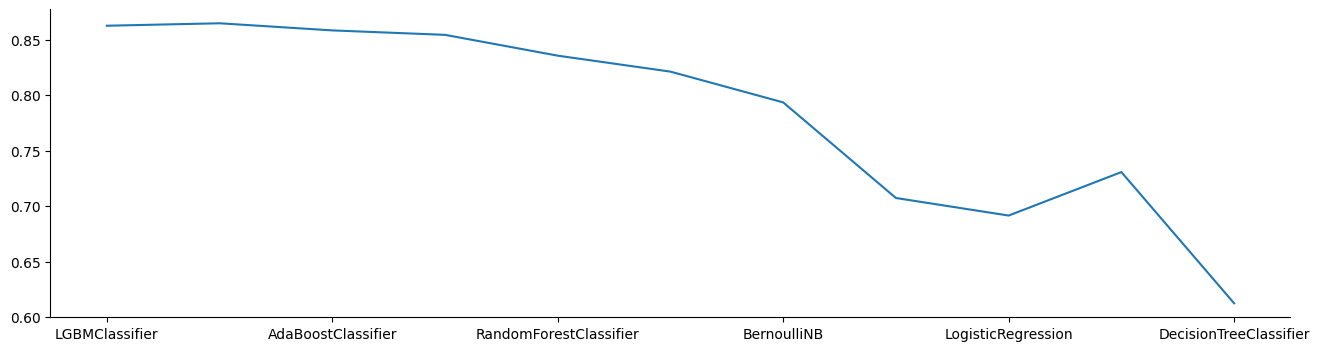

In [23]:
from matplotlib import pyplot as plt
results_unbalanced[0].plot(kind='line', figsize=(16, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

#### Comparing Results

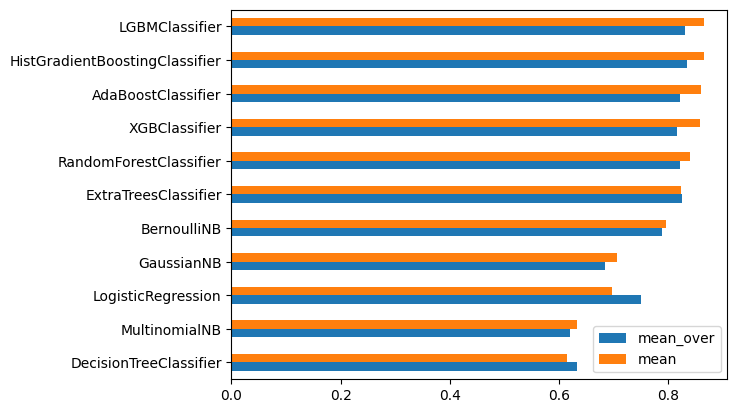

In [ ]:
df_compare = pd.DataFrame(results_oversampling['mean']).rename(columns={'mean':'mean_over'})
df_compare = df_compare.join(results_unbalanced['mean'])
df_compare = df_compare.sort_values(by=['mean'], ascending=True)
ax = df_compare.plot.barh()

In [ ]:
df_compare = df_compare.sort_values(by=['mean'], ascending=False)
df_compare['difference'] = df_compare['mean_over'] - df_compare['mean']
df_compare

mean_over      mean  difference
LGBMClassifier                   0.831334  0.864984   -0.033649
HistGradientBoostingClassifier   0.833341  0.864955   -0.031614
AdaBoostClassifier               0.821372  0.859480   -0.038108
XGBClassifier                    0.816551  0.857017   -0.040465
RandomForestClassifier           0.821493  0.840187   -0.018693
ExtraTreesClassifier             0.824338  0.823433    0.000905
BernoulliNB                      0.788732  0.795880   -0.007148
GaussianNB                       0.684538  0.705393   -0.020855
LogisticRegression               0.749066  0.696028    0.053038
MultinomialNB                    0.620249  0.633364   -0.013116
DecisionTreeClassifier           0.633141  0.613600    0.019540

As we can see, oversampling made more harm than good in most of our models.

The best result was achieved by **LGBMClassifier**. Let's fine tuning it's parameters then.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

### Hyperparameter Tuning

Since we're no longer using oversampling, we can perform optimization directly with cross_validation.

In [15]:
def param_opt(model, params, X, y, opt_method='', n_iter=10, score='roc_auc', n_splits=5, shuffle=False, n_jobs=4):
  """
  Function to optimize algorithm hyperparameters
     If opt_method = 'Grid' then all combinations of hyperparameters will be tested for GridSearchCV
     If opt_method = 'Random', 10 hyperparameters will be tested randomly
     If opt_method = 'Bayes', 10 hyperparameters will be randomly tested and then Bayesian optimization will be performed (default)
  """

  # Defining kfold
  if shuffle == False:
    val_random = None
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=val_random)

  if opt_method.upper() == 'GRID':
    grid = GridSearchCV(model, params, cv=kfold, n_jobs=n_jobs, scoring=score)
  elif opt_method.upper() == 'RANDOM':
    grid = RandomizedSearchCV(model, params, cv=kfold, n_iter=n_iter, n_jobs=n_jobs, random_state=val_random, scoring=score)
  elif opt_method.upper() == 'BAYES':
    # Optimizers['GP', 'RF', 'ET', 'GBRT']: https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html#skopt.Optimizer
    grid = BayesSearchCV(model, params, cv=kfold, n_iter=n_iter, n_jobs=n_jobs, optimizer_kwargs={'base_estimator':'GP'}, random_state=val_random, scoring=score)

  # Training model
  grid.fit(X, y)

  # Best hiperparameters
  best_params = dict(grid.best_params_)
  print("Best params:", best_params)

  # Best score
  best_score = grid.best_score_
  print(f"Best score({score}): {best_score:.5}\n")

  return best_params

In [27]:
# Listing hyperparameters
params = {}
params['num_leaves'] = [10, 20, 31, 50]                         # (default=31)
params['max_depth'] = [-1, 1]                                   # (default=-1)
params['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5]  # (default=0.1)
params['n_estimators'] = [50, 100, 150, 200, 250, 300]          # (default=100)
params['reg_alpha'] = [0., 0.0001, 0.001, 0.01, 0.1, 0.3]       # (default=0.)
params['reg_lambda'] = [0., 0.0001, 0.001, 0.01, 0.1, 0.3]      # (default=0.)
params['random_state'] = [42]                                   # (default=None)
params['n_jobs'] = [-1]                                         # (default=None)

n_comb = np.prod([len(params[key]) for key in params.keys()])
print(f'Possible matches: {n_comb}\n')

Possible matches: 10368



In [28]:
# Tuning hyperparameters Bayesian method
best_param_b = param_opt(model=LGBMClassifier(verbose=-1), params=params,
                       X=X_train, y=y_train, opt_method='bayes',
                       score='roc_auc', n_iter=50, n_splits=5)

/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [-1, 1] was inferred to Integer(low=-1, high=1, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(-1, 1), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [-1, 1] was inferred to Integer(low=-1, high=1, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(-1, 1), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [-1, 1] was inferred to Integer(low=-1, high=1, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to C

Best params: {'learning_rate': 0.1, 'max_depth': 0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'random_state': 42, 'reg_alpha': 0.0001, 'reg_lambda': 0.1}
Best score(roc_auc): 0.86525



In [29]:
# Tuning hyperparameters random method
best_param_r = param_opt(model=LGBMClassifier(verbose=-1), params=params,
                       X=X_train, y=y_train, opt_method='random',
                       score='roc_auc', n_iter=50, n_splits=5)

KeyboardInterrupt: 

In [30]:
best_param = best_param_b
best_param

{'learning_rate': 0.1,
 'max_depth': 0,
 'n_estimators': 50,
 'n_jobs': -1,
 'num_leaves': 31,
 'random_state': 42,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.1}

In [20]:
best_param_s = {'learning_rate': 0.1,
 'max_depth': 0,
 'n_estimators': 50,
 'n_jobs': -1,
 'num_leaves': 31,
 'random_state': 42,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.1}

We have a tinny improvement compared with vanilla model, but it's better than nothing.

## Testing

As we're working with a kaggle challenge dataset, the test dataset don't have  labels. To verify the performance achieved by the model, we'll have to upload the prediction directly to the platform.

In [16]:
# Filling null values with median of df_train
X_test = df_test.drop(columns=['SeriousDlqin2yrs'])
X_test['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
X_test['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

<ipython-input-16-215fae89b672>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
<ipython-input-16-215fae89b672>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [17]:
X_test.head()

RevolvingUtilizationOfUnsecuredLines  age  \
1                              0.885519   43   
2                              0.463295   57   
3                              0.043275   59   
4                              0.280308   38   
5                              1.000000   27   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     0   0.177513         5700.0   
2                                     0   0.527237         9141.0   
3                                     0   0.687648         5083.0   
4                                     1   0.925961         3200.0   
5                                     0   0.019917         3865.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                                4                        0   
2                               15                        0   
3                               12                        0   
4                                7                        0   
5                                4                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                             0                                     0   
2                             4                                     0   
3                             1                                     0   
4                             2                                     0   
5                             0                                     0   

   NumberOfDependents  
1                 0.0  
2                 2.0  
3                 2.0  
4                 0.0  
5                 1.0

In [18]:
X_test.describe()

RevolvingUtilizationOfUnsecuredLines            age  \
count                         101503.000000  101503.000000   
mean                               5.310000      52.405436   
std                              196.156039      14.779756   
min                                0.000000      21.000000   
25%                                0.030131      41.000000   
50%                                0.152586      52.000000   
75%                                0.564225      63.000000   
max                            21821.000000     104.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         101503.000000  101503.000000   1.015030e+05   
mean                               0.453770     344.475020   6.566861e+03   
std                                4.538487    1632.595231   3.269909e+04   
min                                0.000000       0.000000   0.000000e+00   
25%                                0.000000       0.173423   3.900000e+03   
50%                                0.000000       0.364260   5.400000e+03   
75%                                0.000000       0.851619   7.374000e+03   
max                               98.000000  268326.000000   7.727000e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                    101503.000000            101503.000000   
mean                          8.453514                 0.296691   
std                           5.144100                 4.515859   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           8.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          85.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                 101503.000000                         101503.000000   
mean                       1.013074                              0.270317   
std                        1.110253                              4.503578   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                       37.000000                             98.000000   

       NumberOfDependents  
count        101503.00000  
mean              0.74915  
std               1.12860  
min               0.00000  
25%               0.00000  
50%               0.00000  
75%               1.00000  
max              43.00000

In [21]:
final_model = LGBMClassifier(verbose=-1, **best_param_s).fit(X_train, y_train)

In [22]:
predicted_values = pd.DataFrame(final_model.predict_proba(X_test)[:, 1]).reset_index()
predicted_values.rename(columns={'index':'Id', 0:'Probability'}, inplace=True)
predicted_values['Id'] = predicted_values['Id'] + 1
predicted_values['Id'] = predicted_values['Id'].astype(int)
predicted_values

Id  Probability
0            1     0.072066
1            2     0.054606
2            3     0.010487
3            4     0.080498
4            5     0.113857
...        ...          ...
101498  101499     0.031456
101499  101500     0.408894
101500  101501     0.005881
101501  101502     0.067669
101502  101503     0.038368

[101503 rows x 2 columns]

In [23]:


target_value = predicted_values.drop(columns=['Id'])

In [26]:

# Assuming predicted_values and X_test are already defined as in the provided code.
combined_test_result_df = pd.concat([X_test.reset_index(), predicted_values['Probability']], axis=1)
combined_test_result_df.to_csv('combined__result_data.csv', index=False)
combined_test_result_df.head()

index  RevolvingUtilizationOfUnsecuredLines  age  \
0      1                              0.885519   43   
1      2                              0.463295   57   
2      3                              0.043275   59   
3      4                              0.280308   38   
4      5                              1.000000   27   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     0   0.177513         5700.0   
1                                     0   0.527237         9141.0   
2                                     0   0.687648         5083.0   
3                                     1   0.925961         3200.0   
4                                     0   0.019917         3865.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                4                        0   
1                               15                        0   
2                               12                        0   
3                                7                        0   
4                                4                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             0                                     0   
1                             4                                     0   
2                             1                                     0   
3                             2                                     0   
4                             0                                     0   

   NumberOfDependents  Probability  
0                 0.0     0.072066  
1                 2.0     0.054606  
2                 2.0     0.010487  
3                 0.0     0.080498  
4                 1.0     0.113857

In [33]:
combined_test_result_df.describe()

index  RevolvingUtilizationOfUnsecuredLines            age  \
count  101503.000000                         101503.000000  101503.000000   
mean    50752.000000                              5.310000      52.405436   
std     29301.536524                            196.156039      14.779756   
min         1.000000                              0.000000      21.000000   
25%     25376.500000                              0.030131      41.000000   
50%     50752.000000                              0.152586      52.000000   
75%     76127.500000                              0.564225      63.000000   
max    101503.000000                          21821.000000     104.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         101503.000000  101503.000000   1.015030e+05   
mean                               0.453770     344.475020   6.566861e+03   
std                                4.538487    1632.595231   3.269909e+04   
min                                0.000000       0.000000   0.000000e+00   
25%                                0.000000       0.173423   3.900000e+03   
50%                                0.000000       0.364260   5.400000e+03   
75%                                0.000000       0.851619   7.374000e+03   
max                               98.000000  268326.000000   7.727000e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                    101503.000000            101503.000000   
mean                          8.453514                 0.296691   
std                           5.144100                 4.515859   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           8.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          85.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                 101503.000000                         101503.000000   
mean                       1.013074                              0.270317   
std                        1.110253                              4.503578   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                       37.000000                             98.000000   

       NumberOfDependents    Probability  
count        101503.00000  101503.000000  
mean              0.74915       0.067148  
std               1.12860       0.114691  
min               0.00000       0.004195  
25%               0.00000       0.010113  
50%               0.00000       0.021834  
75%               1.00000       0.064671  
max              43.00000       0.830692

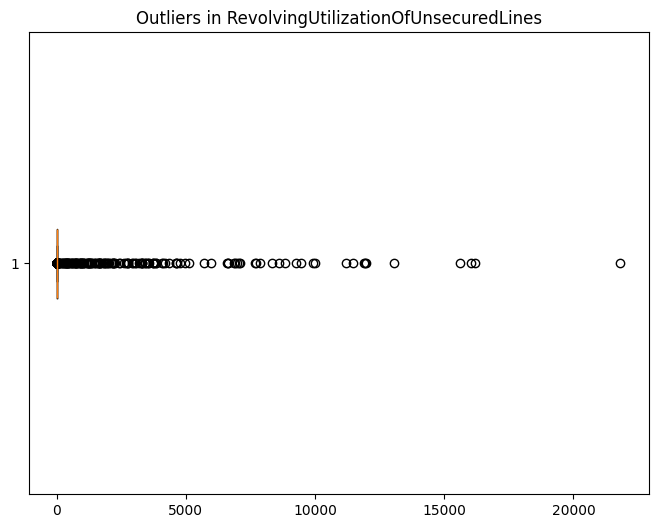

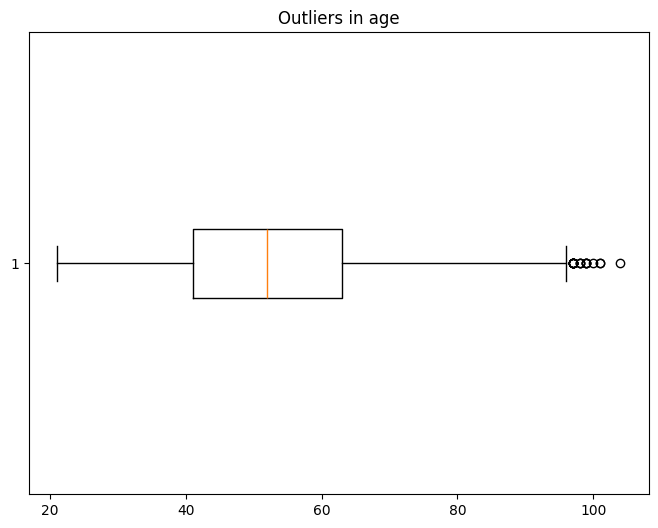

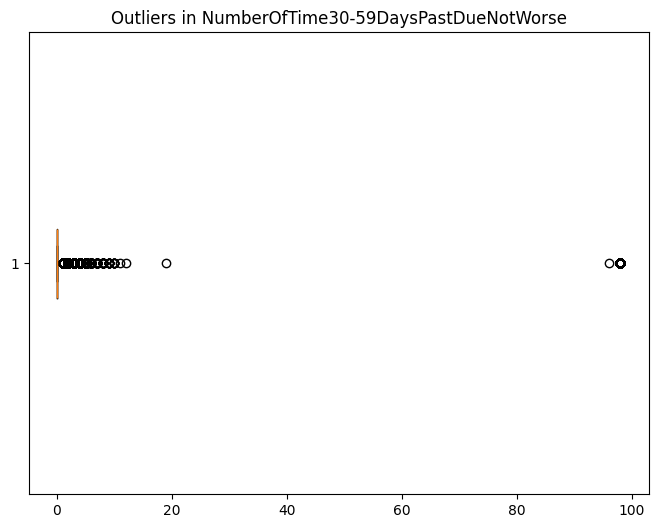

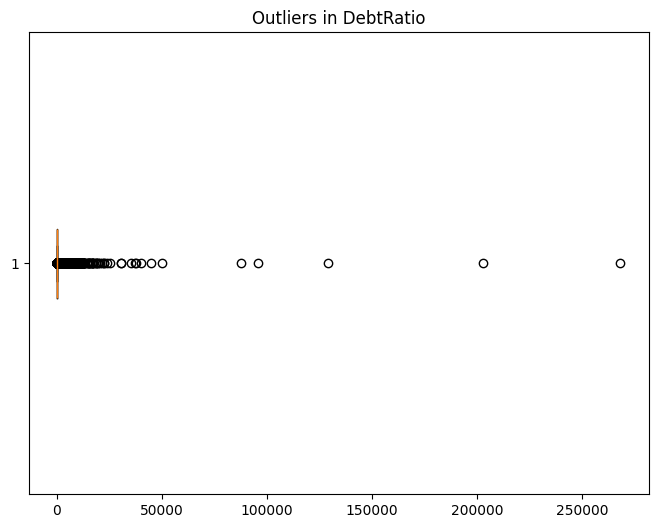

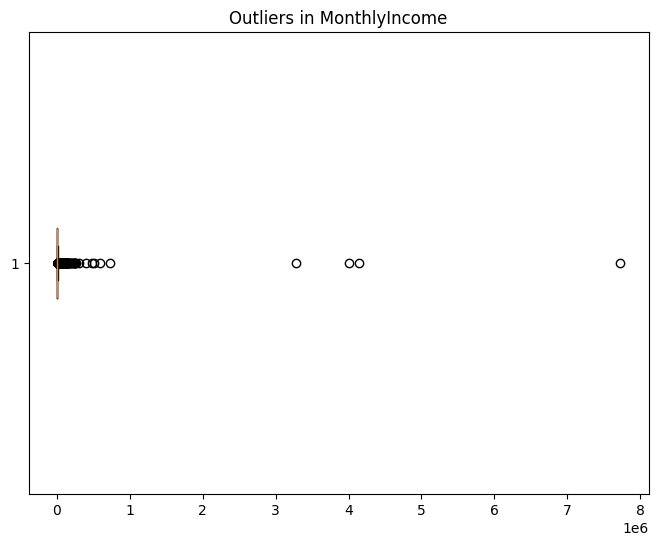

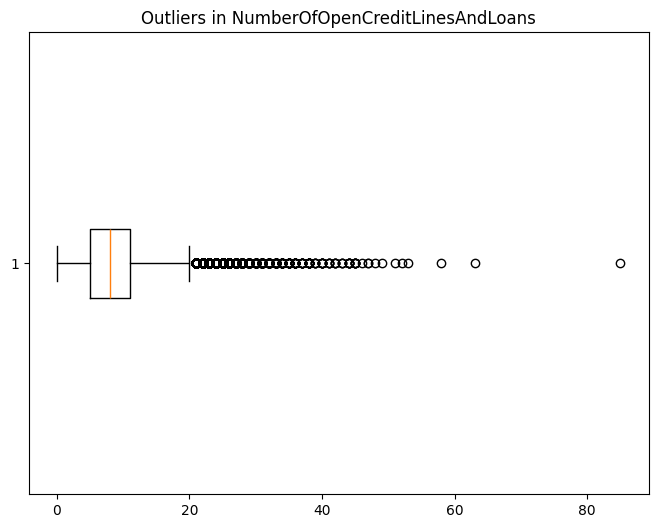

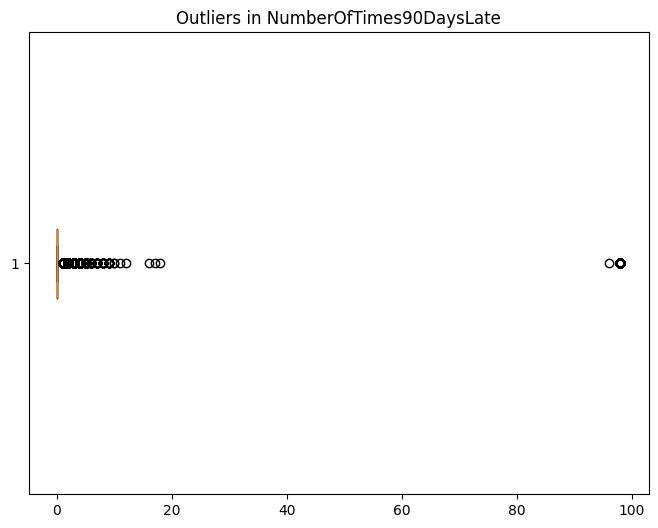

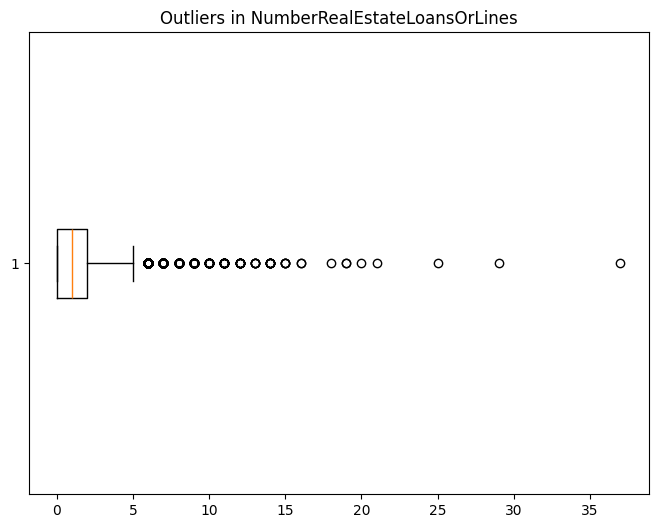

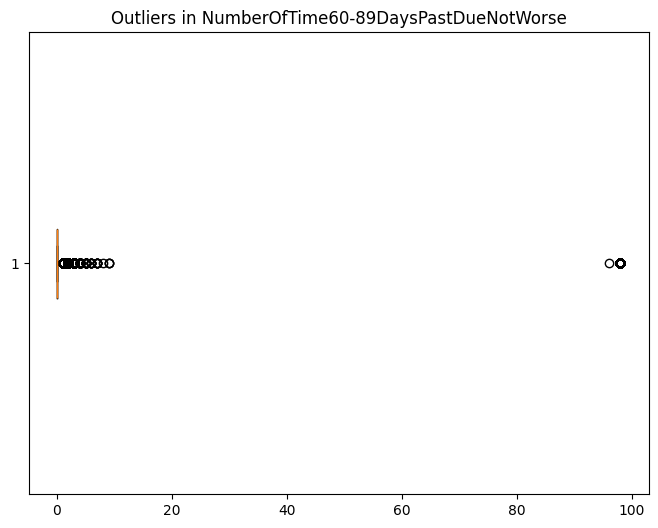

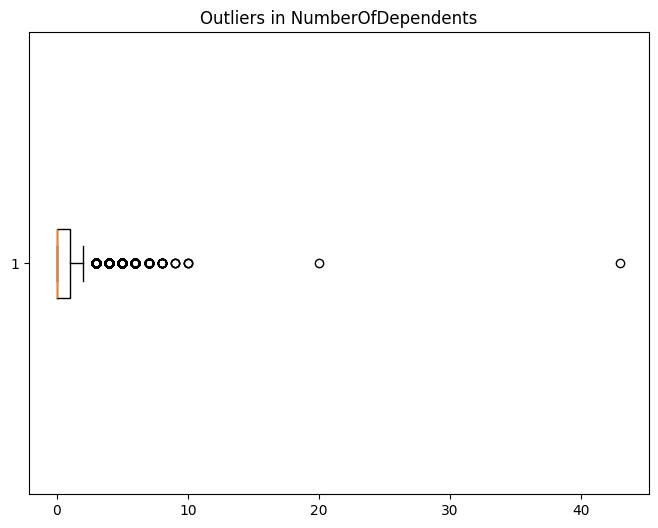

In [28]:

import os
import matplotlib.pyplot as plt

# Create the 'outliers' directory if it doesn't exist
if not os.path.exists('outliers'):
    os.makedirs('outliers')

# Assuming combined_test_result_df is defined as in your provided code
# and contains columns 'RevolvingUtilizationOfUnsecuredLines', 'age', etc.

for col in combined_test_result_df.columns:
    if col not in ['index', 'Probability']:  # Exclude specified columns
        plt.figure(figsize=(8, 6))
        plt.boxplot(combined_test_result_df[col], vert=False)  # Horizontal boxplot
        plt.title(f'Outliers in {col}')

        # Save the plot to the 'outliers' directory as a PNG file
        plt.savefig(os.path.join('outliers', f'{col}_outliers.png'))

        plt.show() #show the plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [34]:


import pandas as pd
import numpy as np

def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0)
        Q3 = df_cleaned[col].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

# Assuming 'combined_test_result_df' is your DataFrame
# Replace with the actual name of your DataFrame if different

# Specify columns for outlier removal
columns_to_clean = ['DebtRatio','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents']

# ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse',
#                     'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
#                     'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
#                     'NumberOfDependents']
# Call the function to remove outliers
removed_outlier_df = remove_outliers_iqr(combined_test_result_df, columns_to_clean)


In [35]:
removed_outlier_df.describe()

index  RevolvingUtilizationOfUnsecuredLines           age  \
count   97548.000000                          97548.000000  97548.000000   
mean    50738.783973                              5.157819     52.354369   
std     29305.461006                            191.791463     14.921296   
min         1.000000                              0.000000     21.000000   
25%     25352.750000                              0.029676     41.000000   
50%     50746.500000                              0.150409     52.000000   
75%     76131.250000                              0.564903     63.000000   
max    101503.000000                          21821.000000    104.000000   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
count                          97548.000000  97548.000000   9.754800e+04   
mean                               0.459015    185.692892   6.576516e+03   
std                                4.626064    558.705018   3.333705e+04   
min                                0.000000      0.000000   0.000000e+00   
25%                                0.000000      0.166062   3.800000e+03   
50%                                0.000000      0.349107   5.400000e+03   
75%                                0.000000      0.719157   7.500000e+03   
max                               98.000000   3096.000000   7.727000e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                     97548.000000             97548.000000   
mean                          8.297402                 0.306434   
std                           4.997750                 4.605565   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           7.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          37.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                  97548.000000                          97548.000000   
mean                       0.944479                              0.278458   
std                        0.960694                              4.593127   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                        5.000000                             98.000000   

       NumberOfDependents   Probability  
count        97548.000000  97548.000000  
mean             0.743296      0.066869  
std              1.091669      0.114647  
min              0.000000      0.004195  
25%              0.000000      0.010021  
50%              0.000000      0.021450  
75%              1.000000      0.064191  
max              5.000000      0.830692

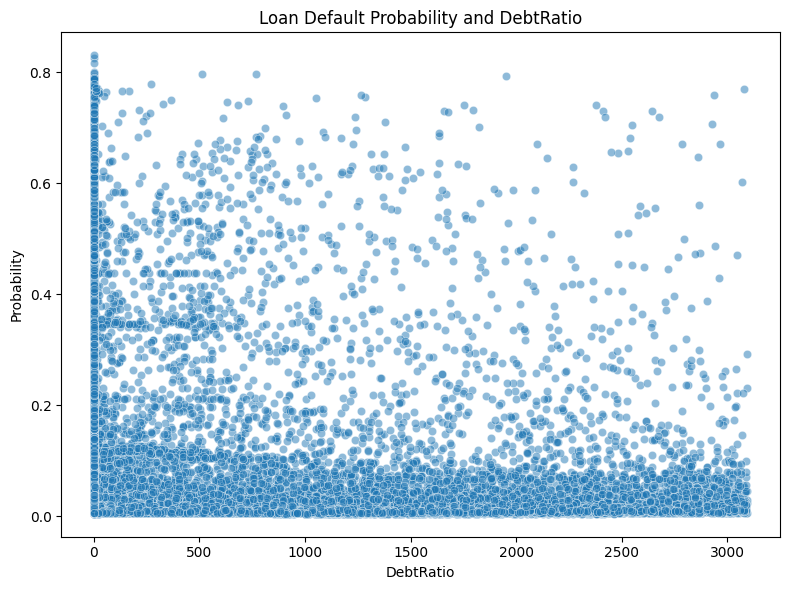

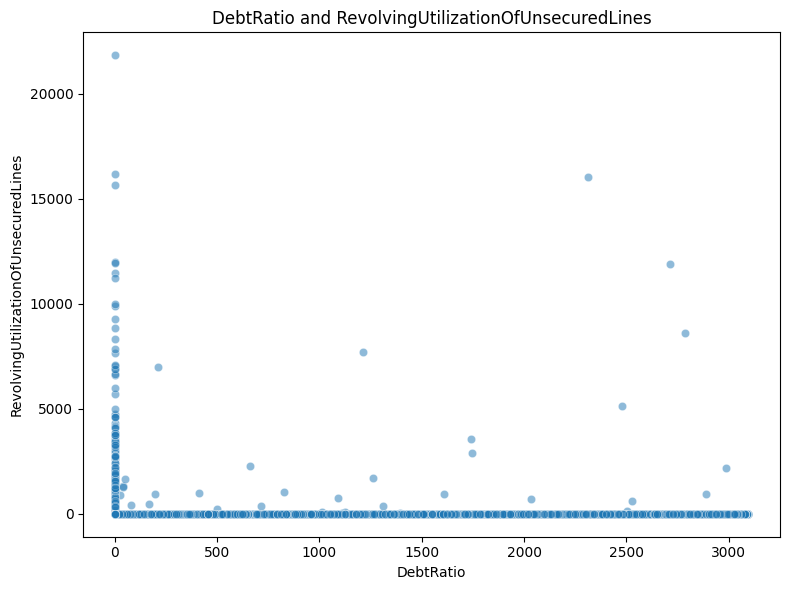

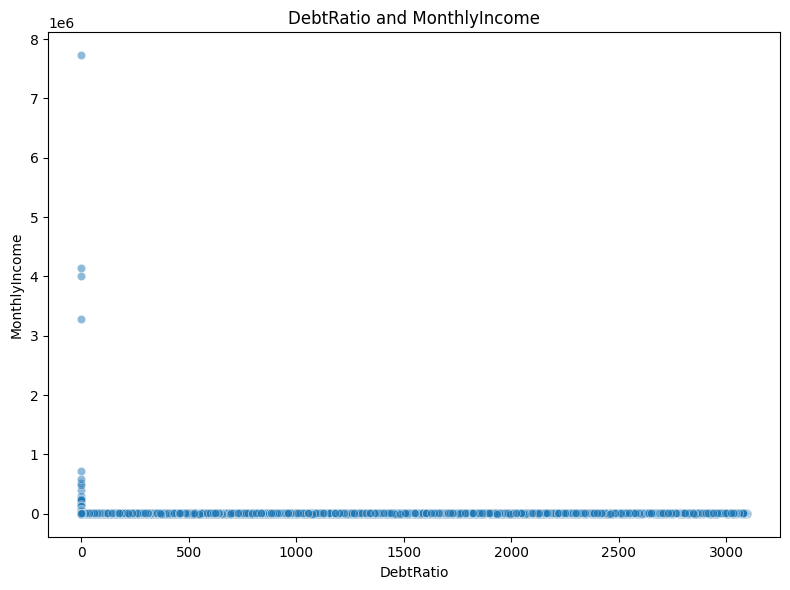

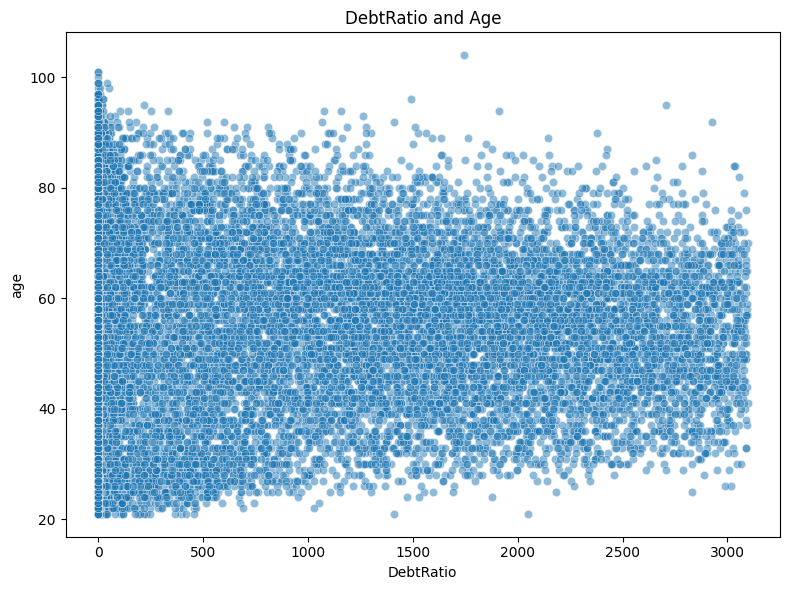

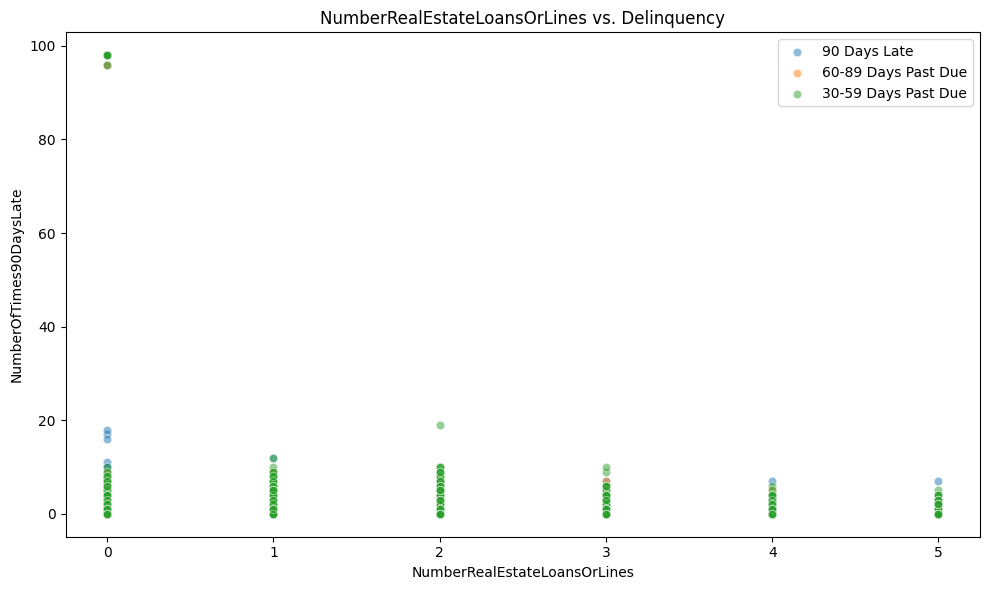

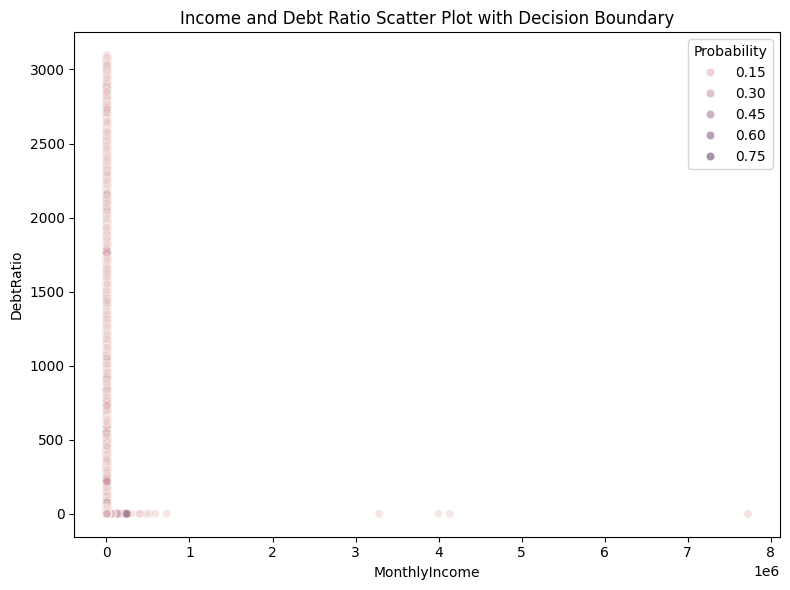

In [36]:
# prompt: prompt: Possible visualizations: I want below visualisation graphs for above resulted df. give beautiful appealing graphs. can you keep probability as vue where suitable and also save all the graphs to folder graphs and also plot it. Make sure that the graphs points are not very dense
# # Loan Default Probability and DebtRatio
# # DebtRatio and RevolvingUtilizationOfUnsecuredLines
# # DebtRatio and MonthlyIncome
# # DebtRatio and Age
# # NumberRealEstateLoansOrLines and NumberOfTimes90DaysLate/NumberOfTime60-89DaysPastDueNotWorse/NumberOfTime30-59DaysPastDueNotWorse
# # Income and Debt Ratio Scatter Plot with Decision Boundary

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create the 'graphs' directory if it doesn't exist
if not os.path.exists('graphs_outlier'):
    os.makedirs('graphs_outlier')

# Function to save plots
def save_plot(plot, filename):
    plt.tight_layout()
    plot.savefig(os.path.join('graphs_outlier', filename))


# Loan Default Probability and DebtRatio
plt.figure(figsize=(8, 6))
sns.scatterplot(x='DebtRatio', y='Probability', data=removed_outlier_df, alpha=0.5)  # Reduced alpha for less dense points
plt.title('Loan Default Probability and DebtRatio')
save_plot(plt, 'loan_default_probability_vs_debt_ratio.png')
plt.show()

# DebtRatio and RevolvingUtilizationOfUnsecuredLines
plt.figure(figsize=(8, 6))
sns.scatterplot(x='DebtRatio', y='RevolvingUtilizationOfUnsecuredLines', data=removed_outlier_df, alpha=0.5)
plt.title('DebtRatio and RevolvingUtilizationOfUnsecuredLines')
save_plot(plt, 'debt_ratio_vs_revolving_utilization.png')
plt.show()

# DebtRatio and MonthlyIncome
plt.figure(figsize=(8, 6))
sns.scatterplot(x='DebtRatio', y='MonthlyIncome', data=removed_outlier_df, alpha=0.5)
plt.title('DebtRatio and MonthlyIncome')
save_plot(plt, 'debt_ratio_vs_monthly_income.png')
plt.show()

# DebtRatio and Age
plt.figure(figsize=(8, 6))
sns.scatterplot(x='DebtRatio', y='age', data=removed_outlier_df, alpha=0.5)
plt.title('DebtRatio and Age')
save_plot(plt, 'debt_ratio_vs_age.png')
plt.show()

# NumberRealEstateLoansOrLines and NumberOfTimes90DaysLate/NumberOfTime60-89DaysPastDueNotWorse/NumberOfTime30-59DaysPastDueNotWorse
plt.figure(figsize=(10, 6))
sns.scatterplot(x='NumberRealEstateLoansOrLines', y='NumberOfTimes90DaysLate', data=removed_outlier_df, alpha=0.5)
sns.scatterplot(x='NumberRealEstateLoansOrLines', y='NumberOfTime60-89DaysPastDueNotWorse', data=removed_outlier_df, alpha=0.5)
sns.scatterplot(x='NumberRealEstateLoansOrLines', y='NumberOfTime30-59DaysPastDueNotWorse', data=removed_outlier_df, alpha=0.5)
plt.title('NumberRealEstateLoansOrLines vs. Delinquency')
plt.legend(['90 Days Late', '60-89 Days Past Due', '30-59 Days Past Due'])
save_plot(plt, 'real_estate_loans_vs_delinquency.png')
plt.show()

# Income and Debt Ratio Scatter Plot (replace with your decision boundary plotting code)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='MonthlyIncome', y='DebtRatio', data=removed_outlier_df, alpha=0.5, hue='Probability') #hue for probability
plt.title('Income and Debt Ratio Scatter Plot with Decision Boundary') # Title updated
save_plot(plt, 'income_debt_ratio_scatter.png')
plt.show()

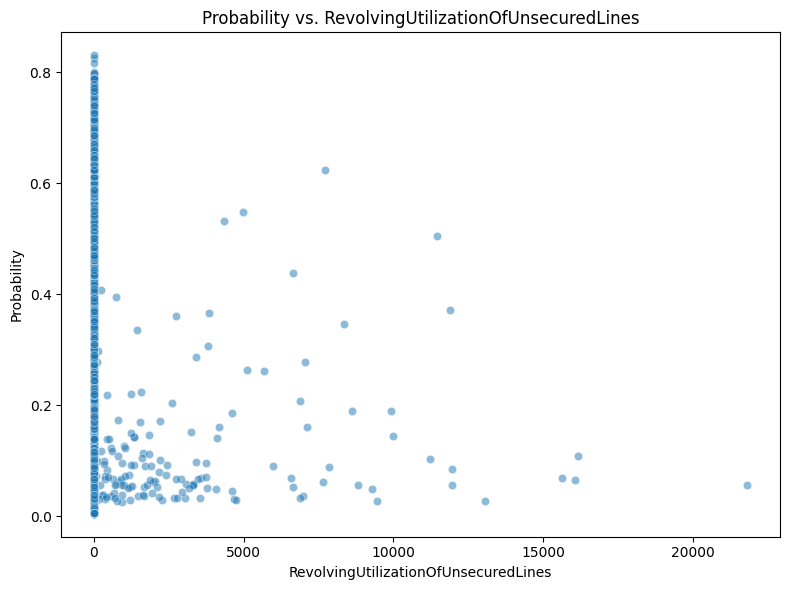

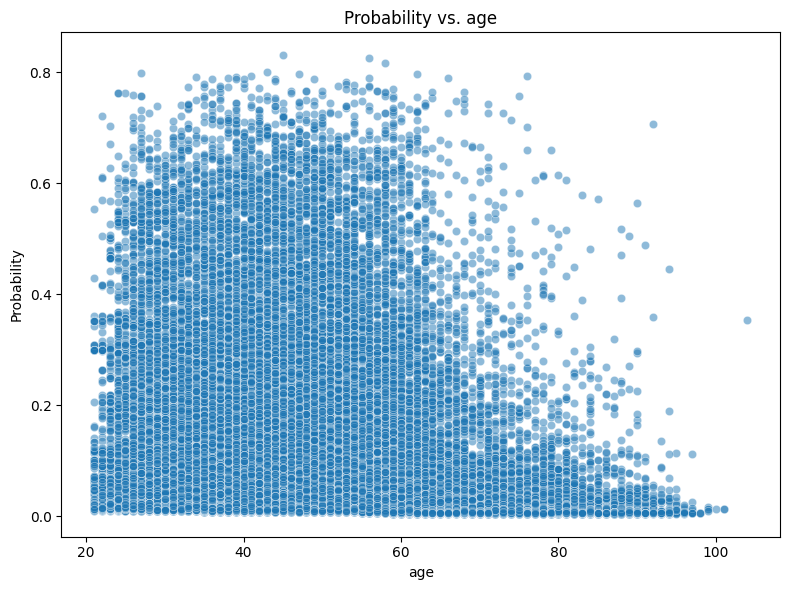

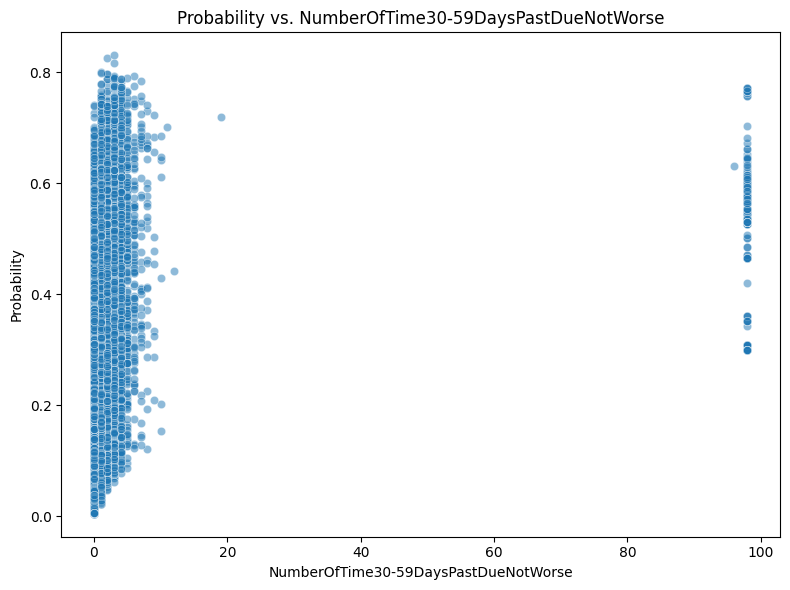

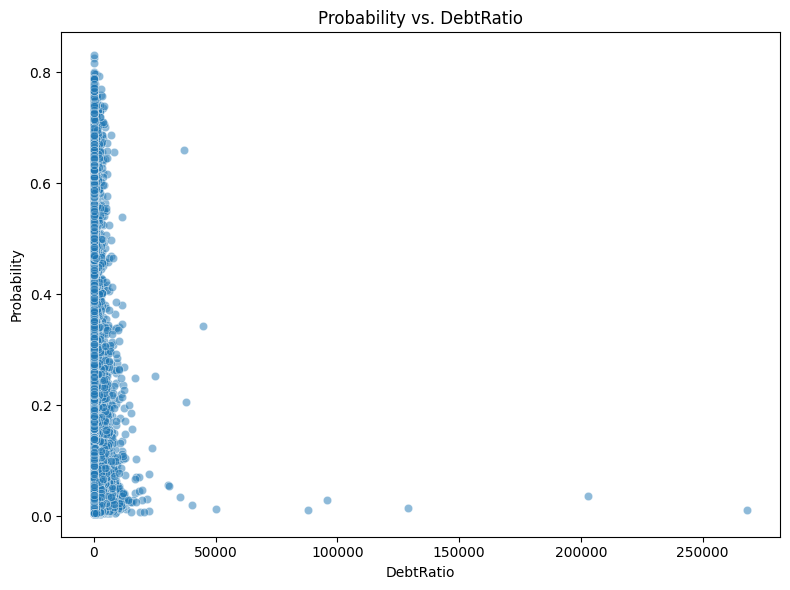

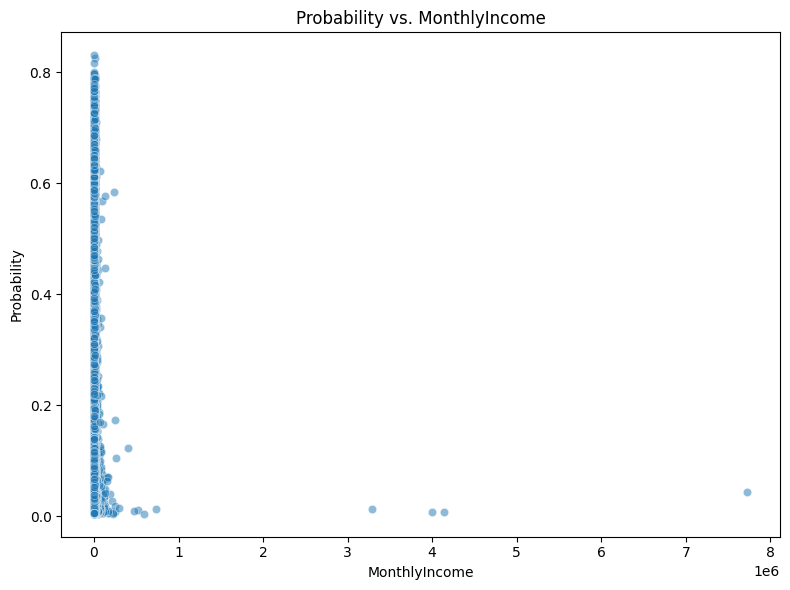

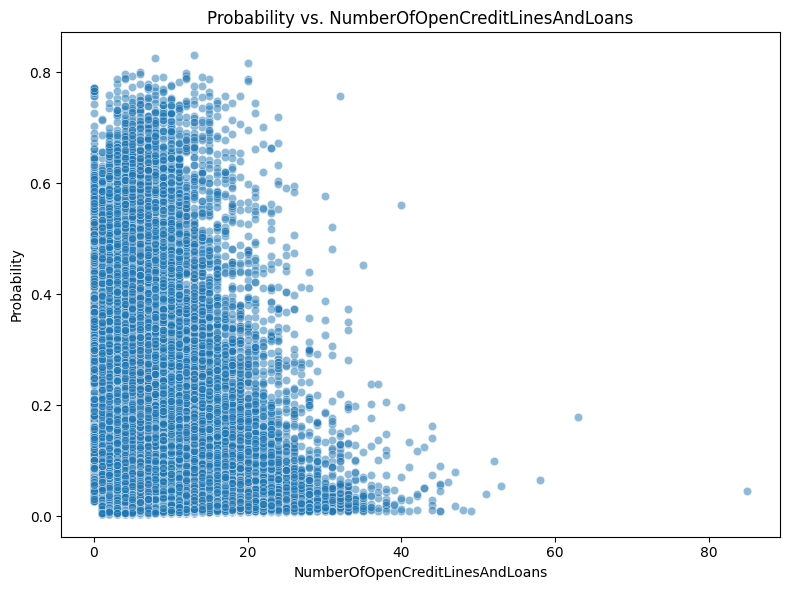

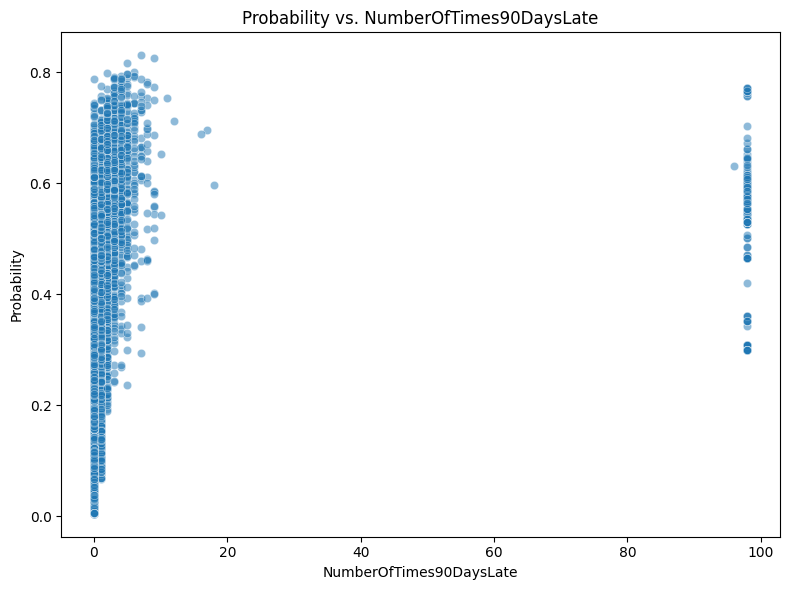

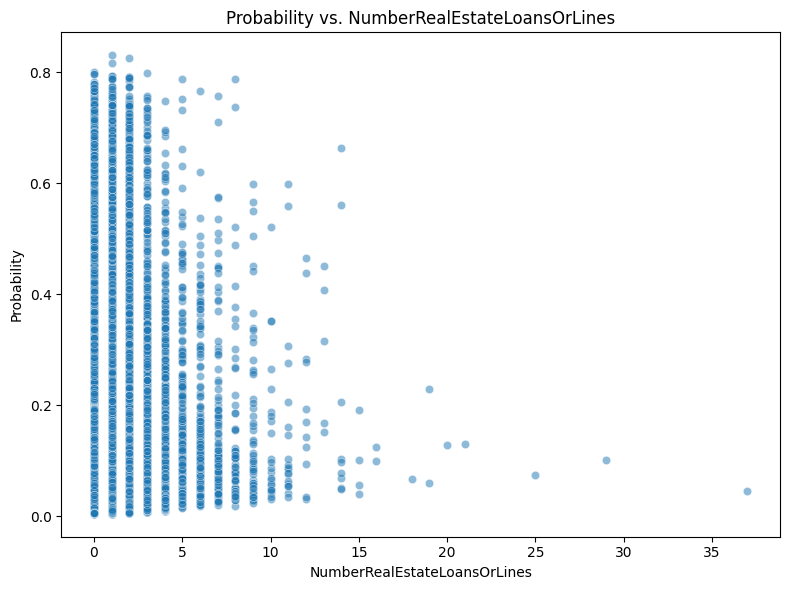

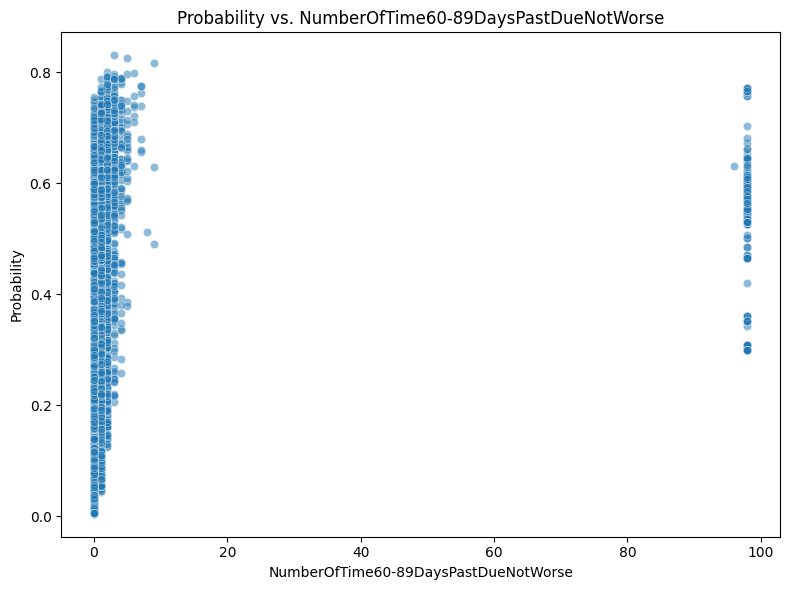

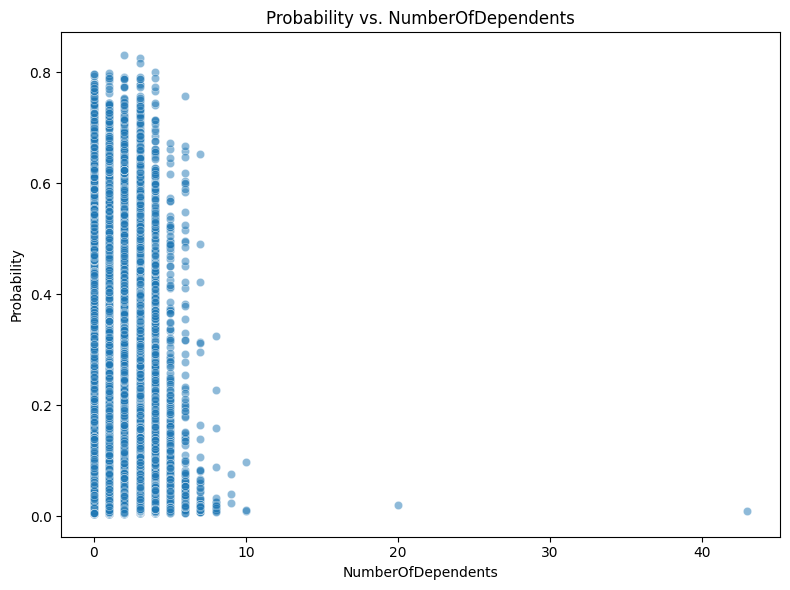

In [37]:
# prompt: Can you also give me visualization plots of all the features with probability as probability is predicted valies give other features, so I want to get an idea how each features is related to probability. give beautiful, clear graphs and also save it to folder named FeatureVsProb. I do not want it with index column though

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create the 'FeatureVsProb' directory if it doesn't exist
if not os.path.exists('FeatureVsProb'):
    os.makedirs('FeatureVsProb')

# Function to save plots
def save_plot(plot, filename):
    plt.tight_layout()
    plot.savefig(os.path.join('FeatureVsProb', filename))


for col in combined_test_result_df.columns:
    if col not in ['index', 'Probability']:  # Exclude specified columns
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=col, y='Probability', data=combined_test_result_df, alpha=0.5)
        plt.title(f'Probability vs. {col}')
        save_plot(plt, f'probability_vs_{col}.png')
        plt.show()

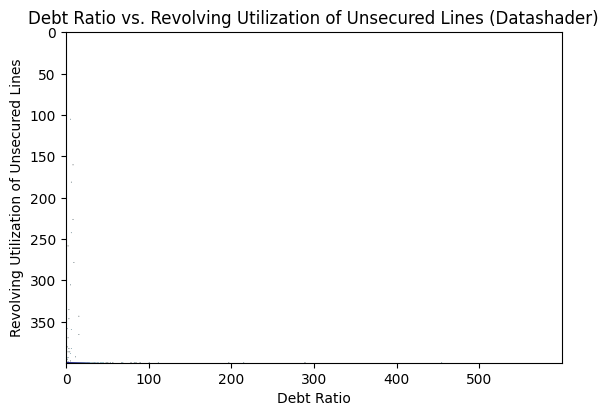

In [41]:
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import plotly.express as px

# Sample the data using Datashader for faster plotting
cvs = ds.Canvas(plot_width=600, plot_height=400)
agg = cvs.points(combined_test_result_df, 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', ds.count())
img = tf.shade(agg, cmap=['lightblue', 'darkblue'])

# Display the plot
plt.imshow(img.to_pil())
plt.title('Debt Ratio vs. Revolving Utilization of Unsecured Lines (Datashader)')
plt.xlabel('Debt Ratio')
plt.ylabel('Revolving Utilization of Unsecured Lines')
plt.show()

# Create an interactive plot using Plotly
fig = px.scatter(combined_test_result_df, x='DebtRatio', y='MonthlyIncome', color='Probability',
                  title='Debt Ratio vs. Monthly Income (Plotly)')
fig.show()

In [40]:
!pip install datashader
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.3 MB/s eta 0:00:00


KeyboardInterrupt: 

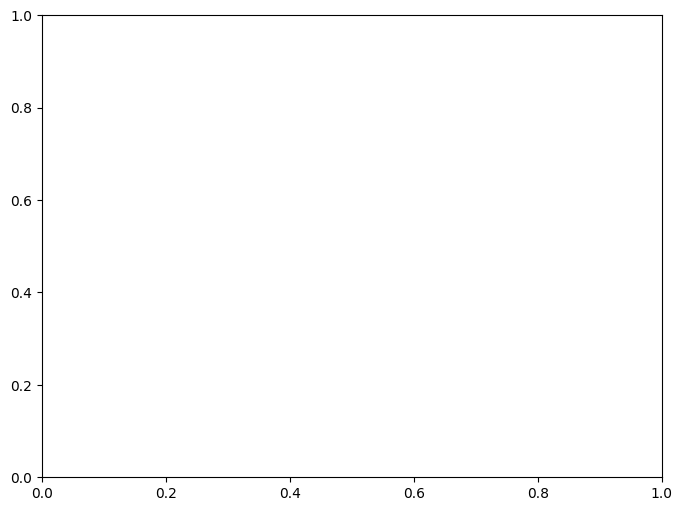

In [36]:
# prompt: Possible visualizations: I want below visualisation graphs for above resulted df. But the visualization should be appealing and well styled. you can use some advanced library if needed
# Loan Default Probability and DebtRatio
# DebtRatio and RevolvingUtilizationOfUnsecuredLines
# DebtRatio and MonthlyIncome
# DebtRatio and Age
# NumberRealEstateLoansOrLines and NumberOfTimes90DaysLate/NumberOfTime60-89DaysPastDueNotWorse/NumberOfTime30-59DaysPastDueNotWorse
# Income and Debt Ratio Scatter Plot with Decision Boundary

import matplotlib.pyplot as plt
import seaborn as sns

# Loan Default Probability and DebtRatio
plt.figure(figsize=(8, 6))
sns.histplot(combined_test_result_df, x='DebtRatio', hue='Probability', element="step")
plt.title('Loan Default Probability and Debt Ratio')
plt.show()


# DebtRatio and RevolvingUtilizationOfUnsecuredLines
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_test_result_df, x='DebtRatio', y='RevolvingUtilizationOfUnsecuredLines', hue='Probability')
plt.title('Debt Ratio and Revolving Utilization of Unsecured Lines')
plt.show()

# DebtRatio and MonthlyIncome
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_test_result_df, x='DebtRatio', y='MonthlyIncome', hue='Probability')
plt.title('Debt Ratio and Monthly Income')
plt.show()

# DebtRatio and Age
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_test_result_df, x='DebtRatio', y='age', hue='Probability')
plt.title('Debt Ratio and Age')
plt.show()

# NumberRealEstateLoansOrLines and NumberOfTimes90DaysLate/NumberOfTime60-89DaysPastDueNotWorse/NumberOfTime30-59DaysPastDueNotWorse
plt.figure(figsize=(10, 6))
sns.pairplot(data=combined_test_result_df,
             vars=['NumberRealEstateLoansOrLines', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse'],
             hue='Probability')
plt.suptitle('Relationship between Real Estate Loans, Delinquencies, and Default Probability', y=1.02)
plt.show()

# Income and Debt Ratio Scatter Plot with Decision Boundary (requires more complex plotting, a decision boundary is model dependent and you already have your final_model)
# Example (replace with your actual decision boundary logic):
# Assuming 'final_model' is your trained model

# This part is an example, you might have to adjust the code based on your final_model and its specifics.
# Also, a decision boundary is typically derived from a classifier and not a regression probability
# For proper visualization, you need to create a meshgrid of x and y values, predict on that meshgrid and then plot the contour
# The below code will not render correctly until replaced with proper meshgrid generation and contour plotting
import numpy as np
x_min, x_max = combined_test_result_df['MonthlyIncome'].min() - 1000, combined_test_result_df['MonthlyIncome'].max() + 1000
y_min, y_max = combined_test_result_df['DebtRatio'].min() - 0.1, combined_test_result_df['DebtRatio'].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 1000),
                     np.arange(y_min, y_max, 0.1))  # Adjust step sizes if needed

# Example placeholder (replace with your actual prediction)
Z = final_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)


plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_test_result_df, x='MonthlyIncome', y='DebtRatio', hue='Probability')
plt.title('Income and Debt Ratio with Decision Boundary')

plt.show()

In [ ]:
# Exporting results
predicted_values.to_csv('predicted_values.csv', index=False, sep=',', decimal='.')

Kaggle returned scores **~0.867** for private score and **~0.861** for public score. It's a good result, considering that winer got **0.86955**.

Maybe we could improve that creating a stack with the top best performers, but if we would do that we will lost the ability of explainability, seen in next topic.

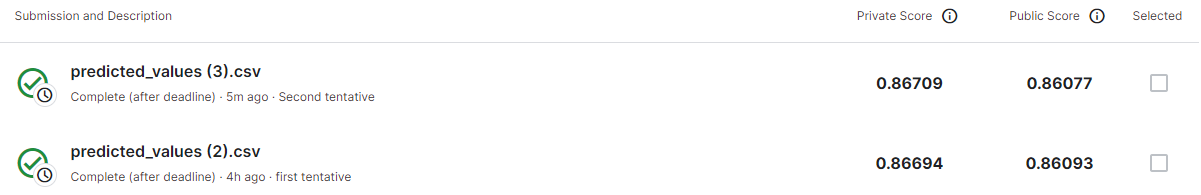

## Explaining

An important part of analysis is to understand which features the model considered most important for decision making. For this challenge, we are going to use SHAP.

In [56]:
def shapley_feature_ranking(shap_values, X, top=10):
  """
  Extract global values from SHAP
  """
  feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
  return pd.DataFrame(
      {
          "features": [X.columns[i] for i in feature_order][::-1],
          "importance": [
              np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
          ][::-1],
      }
  ).head(top)

In [57]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



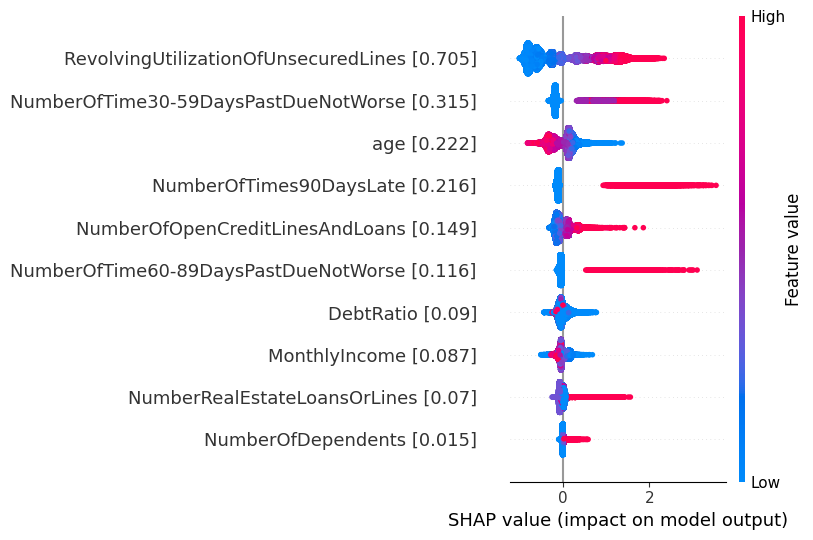

In [59]:
top_features = shapley_feature_ranking(shap_values, X_test, top=X_test.shape[1])
feat_name =  pd.merge(pd.DataFrame({'features':X_test.columns}), top_features, how="left", on=["features"])

feat_val = [
             col + " [" + str(round(feat_name.iloc[i]['importance'], 3)) + "]"
             for i, col in enumerate(feat_name['features'])
             ]

shap.summary_plot(shap_values, X_test, feature_names=feat_val, show=False)
plt.show()

In [72]:
combined_test_result_df.head()

index  RevolvingUtilizationOfUnsecuredLines  age  \
0      1                              0.885519   43   
1      2                              0.463295   57   
2      3                              0.043275   59   
3      4                              0.280308   38   
4      5                              1.000000   27   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     0   0.177513         5700.0   
1                                     0   0.527237         9141.0   
2                                     0   0.687648         5083.0   
3                                     1   0.925961         3200.0   
4                                     0   0.019917         3865.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                4                        0   
1                               15                        0   
2                               12                        0   
3                                7                        0   
4                                4                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             0                                     0   
1                             4                                     0   
2                             1                                     0   
3                             2                                     0   
4                             0                                     0   

   NumberOfDependents  Probability  
0                 0.0     0.072066  
1                 2.0     0.054606  
2                 2.0     0.010487  
3                 0.0     0.080498  
4                 1.0     0.113857

In [73]:
# prompt: is there any other similar plot which can give more insights on the test data prediction and relation to each feature, if yes please write code for that. I also see outliers in each columns can you remove it and then plot it

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def remove_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Assuming X_test is your test data DataFrame
# Replace 'your_dataframe' and 'column_name' with your actual DataFrame and column names
for col in combined_test_result_df.columns:
    combined_test_result_df = remove_outliers(combined_test_result_df, col)


# Example using pairplot for visualizing relationships between features
sns.pairplot(combined_test_result_df, vars=combined_test_result_df.columns[:5], hue="Probability")
plt.show()

# Example using a heatmap to show correlation between features
plt.figure(figsize=(12, 10))
correlation_matrix = combined_test_result_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

# Example using a boxplot to visualize the distribution of each feature
combined_test_result_df.plot(kind='box', subplots=True, layout=(5,5), figsize=(15,10), sharex=False, sharey=False)
plt.show()

# Example using a violin plot
for col in X_test.columns:
  plt.figure(figsize=(8,6))
  sns.violinplot(x=X_test[col])
  plt.title(f'Violin Plot of {col}')
  plt.show()


KeyboardInterrupt: 

In [63]:
X_test

RevolvingUtilizationOfUnsecuredLines  age  \
1                                   0.885519   43   
2                                   0.463295   57   
3                                   0.043275   59   
4                                   0.280308   38   
5                                   1.000000   27   
...                                      ...  ...   
101499                              0.282653   24   
101500                              0.922156   36   
101501                              0.081596   70   
101502                              0.335457   56   
101503                              0.441842   29   

        NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
1                                          0     0.177513         5700.0   
2                                          0     0.527237         9141.0   
3                                          0     0.687648         5083.0   
4                                          1     0.925961         3200.0   
5                                          0     0.019917         3865.0   
...                                      ...          ...            ...   
101499                                     0     0.068522         1400.0   
101500                                     3     0.934217         7615.0   
101501                                     0   836.000000         5400.0   
101502                                     0  3568.000000         5400.0   
101503                                     0     0.198918         5916.0   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                                     4                        0   
2                                    15                        0   
3                                    12                        0   
4                                     7                        0   
5                                     4                        0   
...                                 ...                      ...   
101499                                5                        0   
101500                                8                        0   
101501                                3                        0   
101502                                8                        0   
101503                               12                        0   

        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                                  0                                     0   
2                                  4                                     0   
3                                  1                                     0   
4                                  2                                     0   
5                                  0                                     0   
...                              ...                                   ...   
101499                             0                                     0   
101500                             2                                     0   
101501                             0                                     0   
101502                             2                                     1   
101503                             0                                     0   

        NumberOfDependents  
1                      0.0  
2                      2.0  
3                      2.0  
4                      0.0  
5                      1.0  
...                    ...  
101499                 0.0  
101500                 4.0  
101501                 0.0  
101502                 3.0  
101503                 0.0  

[101503 rows x 10 columns]

In [64]:
predicted_values

Id  Probability
0            1     0.072066
1            2     0.054606
2            3     0.010487
3            4     0.080498
4            5     0.113857
...        ...          ...
101498  101499     0.031456
101499  101500     0.408894
101500  101501     0.005881
101501  101502     0.067669
101502  101503     0.038368

[101503 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



AssertionError: 'shap_values' and 'features' values must have the same number of rows!

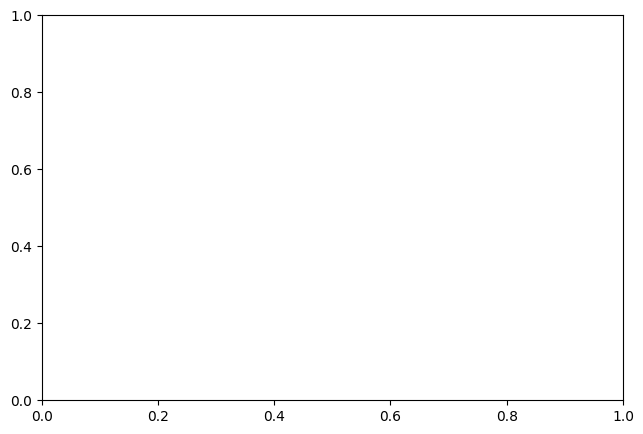

In [65]:
import matplotlib.pyplot as plt
import shap

def plot_feature_impact(model, X_test, y_pred_proba):
    """
    Plots individual feature impact comparison with output probabilities using SHAP values.

    Args:
        model: The trained machine learning model.
        X_test: The test data features.
        y_pred_proba: Predicted probabilities for the test data.
    """

    explainer = shap.TreeExplainer(model)  # Assuming a tree-based model
    shap_values = explainer.shap_values(X_test)

    # Get the actual feature names from your dataset
    feature_names = X_test.columns.tolist()

    # Replace 'feature_name' and 'another_feature' with actual feature names
    # Here, we use the first and second features as an example
    shap.dependence_plot(feature_names[0], shap_values[1], X_test, interaction_index=feature_names[1])

    # Example of plotting probability vs. feature impact for a single instance
    instance_index = 0  # Choose an instance to examine
    plt.figure()
    plt.scatter(shap_values[1][instance_index], y_pred_proba[instance_index])  # shap_value[1] for positive class
    plt.xlabel(f"SHAP Value for Feature ({feature_names[0]})") # Update xlabel
    plt.ylabel("Predicted Probability")
    plt.title(f"Feature Impact vs. Probability (Instance {instance_index})")
    plt.show()


# Example usage (assuming you have 'final_model', 'X_test', and 'y_pred_proba'):
plot_feature_impact(final_model, X_test, predicted_values['Probability'])

---